# Using LSTM for Time Sequence Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras.models import Model
import keras_tuner as kt

In [2]:
df = pd.read_csv('../Datasets/Weekly_U.S.Diesel_Retail_Prices.csv', names=['Date', 'Price'], skiprows=1)
df.head()

,Date,Price
0,1994-03-21,1.106
1,1994-03-28,1.107
2,1994-04-04,1.109
3,1994-04-11,1.108
4,1994-04-18,1.105


### Plot Data
Good Practice!

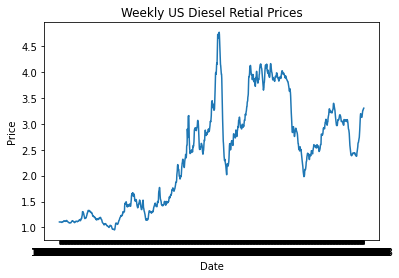

In [3]:
# plot data
plt.plot(df['Date'], df['Price'])
plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Weekly US Diesel Retial Prices')
plt.show()

### Process Data

In [4]:
df.drop('Date', axis=1, inplace=True) # inplace=True will modify the same variable
data = df.values # get values as numpy array

def normalize(data, min, max): # normalize if data values are very large, will return values between 0 and 1
    data = data - min
    data = data / max
    return data

data_normed = normalize(data, data.min(axis=0), data.max(axis=0))
data_normed[:10]

array([[0.03211587],
       [0.03232578],
       [0.03274559],
       [0.03253568],
       [0.03190596],
       [0.03211587],
       [0.03169605],
       [0.03106633],
       [0.03064652],
       [0.03064652]])

In [5]:
split = int(0.8 * len(data_normed))
train, val = data_normed[:split], data_normed[split:]

In [6]:
def windowed_dataset(series, n_past, n_future, batch_size, shift=1):

    # n_past = number of timesteps to look back (x or input to model)
    # n_future = number of timesteps to predict (y or output of model)

    dataset = tf.data.Dataset.from_tensor_slices(series)
    dataset = dataset.window(n_past + n_future, shift=shift, drop_remainder=True)
    dataset = dataset.flat_map(lambda window: window.batch(n_past + n_future)) # flat_map returns a non-iterable, unlike map which returns a list
    # dataset = dataset.shuffle(shuffle_buffer) can only apply to train, and not that important for time series
    dataset = dataset.map(lambda window: (window[:n_past], window[n_past:]))
    dataset = dataset.batch(batch_size).prefetch(1)
    return dataset

batch_size = 32 # affects performance, but impact is not straightforward (i.e. larger batch_size =/= better performance)
n_past = 10
n_future = 10
shift = 1

train_ds = windowed_dataset(series=train, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)
val_ds = windowed_dataset(series=val, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)


In [14]:
xIn = Input((n_past, 1))
x = Bidirectional(LSTM(32, return_sequences=True))(xIn) # set return_sequences = True if there's an LSTM layer afterwards
x = Bidirectional(LSTM(32))(x)
x = Dense(32, activation='swish')(x)
x = Flatten()(x) # alternative: GlobalAvgPool2D() - may lose some accuracy, but smaller output shape than Flatten()
x = Dense(64, activation='swish')(x)
xOut = Dense(n_future)(x)

model = Model(inputs=xIn, outputs=xOut)
model.compile(optimizer='adam', loss='mse', metrics='mse')
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 10, 1)]           0         
                                                                 
 bidirectional (Bidirectiona  (None, 10, 64)           8704      
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 64)               24832     
 nal)                                                            
                                                                 
 dense_3 (Dense)             (None, 32)                2080      
                                                                 
 flatten_1 (Flatten)         (None, 32)                0         
                                                                 
 dense_4 (Dense)             (None, 64)                2112

In [15]:
epochs = 100

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=3, verbose=1)
]

history = model.fit(train_ds, validation_data=val_ds, batch_size=32, epochs=epochs, callbacks=callbacks)

Epoch 1/100
35/35 [==============================] - 7s 52ms/step - loss: 0.0116 - mse: 0.0116 - val_loss: 0.0073 - val_mse: 0.0073 - lr: 0.0010
Epoch 2/100
35/35 [==============================] - 1s 18ms/step - loss: 0.0428 - mse: 0.0428 - val_loss: 0.0460 - val_mse: 0.0460 - lr: 0.0010
Epoch 3/100
35/35 [==============================] - 1s 17ms/step - loss: 0.0145 - mse: 0.0145 - val_loss: 7.6423e-04 - val_mse: 7.6423e-04 - lr: 0.0010
Epoch 4/100
35/35 [==============================] - 1s 17ms/step - loss: 0.0033 - mse: 0.0033 - val_loss: 0.0019 - val_mse: 0.0019 - lr: 0.0010
Epoch 5/100
35/35 [==============================] - 1s 17ms/step - loss: 0.0037 - mse: 0.0037 - val_loss: 0.0030 - val_mse: 0.0030 - lr: 0.0010
Epoch 6/100
32/35 [==========================>...] - ETA: 0s - loss: 0.0024 - mse: 0.0024     
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
35/35 [==============================] - 1s 17ms/step - loss: 0.0028 - mse: 0.0028 - val_loss: 

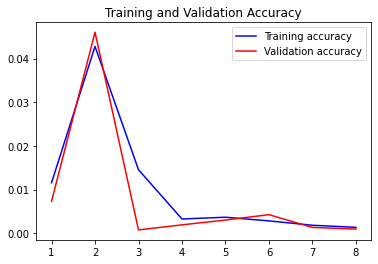

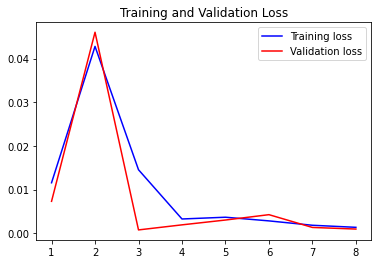

In [17]:
print(history)
acc = history.history['mse']
val_acc = history.history['val_mse']
loss = history.history['loss']
val_loss = history.history['val_loss']

num_epochs = range(1, 8 + 1)

plt.plot(num_epochs, acc, 'b', label='Training accuracy')
plt.plot(num_epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

plt.plot(num_epochs, loss, 'b', label='Training loss')
plt.plot(num_epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [18]:
def unnormalize(data, min, max):
    data = data * max
    data = data + min
    return data

pred = model.predict(val_ds)
preds_unnormed = unnormalize(pred, data.min(axis=0), data.max(axis=0))

In [19]:
print(preds_unnormed[:, 0])
print(preds_unnormed[:, 0].shape)

[2.03911469 2.04260296 2.05005994 2.06299792 2.08150181 2.10510839
 2.13500766 2.16416702 2.19285316 2.22133073 2.2512846  2.28374764
 2.31846346 2.35059129 2.37830346 2.40212685 2.41795189 2.43116027
 2.43821474 2.43621072 2.42769458 2.4160207  2.40805813 2.40507148
 2.4025542  2.4008516  2.39978903 2.39999533 2.40277626 2.41374053
 2.43051128 2.44682146 2.45839937 2.46628654 2.47156515 2.47532672
 2.47850874 2.48704476 2.4957148  2.50262275 2.50921083 2.52195693
 2.53659688 2.55108647 2.56662656 2.58199499 2.59548449 2.60350939
 2.61086457 2.61471388 2.61777394 2.61540234 2.61022765 2.60525146
 2.60384687 2.60523953 2.60886182 2.6118428  2.61322027 2.61284076
 2.61035913 2.6088313  2.61139727 2.6131649  2.60867157 2.59864067
 2.5847417  2.57140853 2.56051865 2.55166815 2.54649162 2.54467799
 2.54633346 2.55204326 2.56210654 2.57608501 2.60738014 2.64318621
 2.67717566 2.7106327  2.74189049 2.76916125 2.79113906 2.81188109
 2.83289856 2.85742005 2.87267746 2.88563099 2.90131887 2.9165

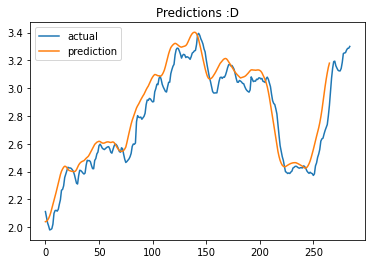

In [20]:
plt.plot(unnormalize(val, data.min(axis=0), data.max(axis=0)), label='actual')
plt.plot(preds_unnormed[:, 0], label='prediction')
plt.legend()
plt.title('Predictions :D')
plt.show()